### Обработка и распознавание изображений, отчёт по лабораторной работе №2. 

Севастопольский Артём, 317

-----

### Цель работы

Требуется разработать и реализовать программу для классификации изображений ладоней, обеспечивающую:
* Ввод и отображение на экране изображений в формате TIF;
* Сегментацию изображений на основе точечных и пространственных преобразований;
* Генерацию признаковых описаний формы ладоней на изображениях;
* Вычисление меры сходства ладоней;
* Кластеризацию изображений.

Задание разделено на 2 части, соответствующие двум уровням сложности &mdash; Intermediate и Expert. В рамках класса Intermediate требуется:
* Найти на изображении ладони точки в кончиках и основаниях пальцев.
* Визуализировать результат для экспертного контроля в виде картинки с ломаной, соединяющей кончили и основания пальцев в правильном порядке.

В рамках класса Expert требуется:
* Найти для каждой ладони 3 наиболее похожих изображения и представить результат в виде таблицы «имя образца – имена ближайших соседей».
* Определить число людей, чьи ладони представлены в изображениях, и составить списки ладоней для каждого, т.е. провести кластеризацию изображений в виде таблицы «Персона No – имена изображений ладоней».

### Описание входных данных.

В качестве исходных данных прилагается набор из 99 цветных изображений формата TIF ладоней разных людей, полученных с помощью сканера, в формате 489×684 с разрешением 72 dpi.


### Описание решения.

Автором было реализовано решение при помощи языка программирования Python 2.7 с использованием IPython Notebook, библиотек OpenCV версии 2.4 и scikit-image. Отчёт по заданию предоставлен в форматах IPython Notebook и HTML.

-----

#### Загрузка необходимых модулей.

In [104]:
import os
from operator import attrgetter
import numpy as np
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import skimage
import skimage.measure
import skimage.morphology
import skimage.filters
import sklearn.neighbors
import sklearn.cluster
import sklearn.preprocessing
import cv2
from IPython.display import display
from joblib import Parallel, delayed
import imhandle as imh
import hands_handle as hh

### Класс Intermediate

Требуется найти на изображении ладони кончики пальцев (fingertips) и основания пальцев (valleys). Опишем предлагаемое решение по шагам.

#### Загрузка изображения.

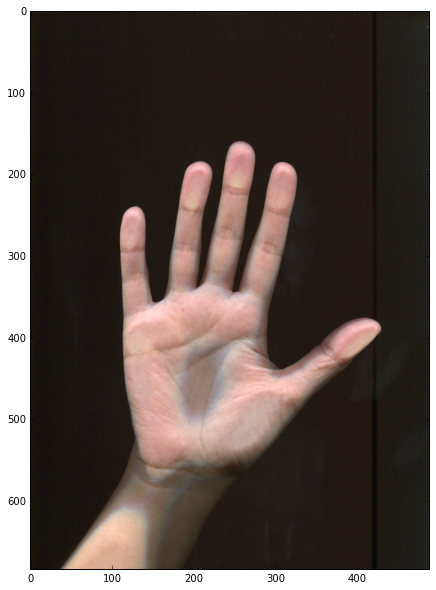

In [30]:
img = imh.load_image('../data/training/001.tif')
imh.show_image(img)

Из изображения извлекается канал **Intensity**: 
$$ I = \frac{R + G + B}{3} $$

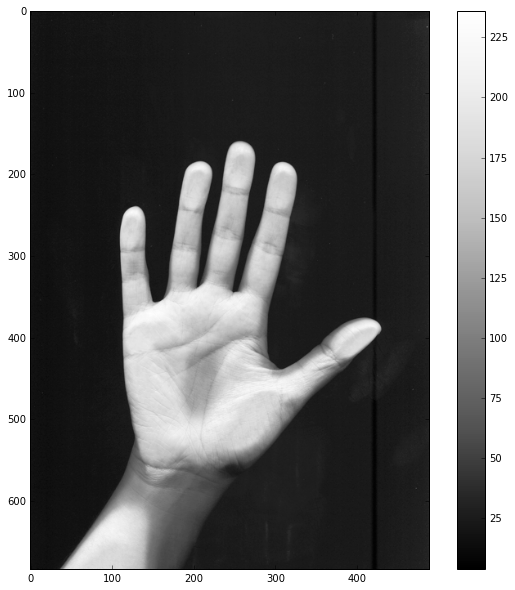

In [31]:
gb = imh.intensity(img)
gb = (gb * 255).astype(np.int64)
imh.show_image(gb)
plt.colorbar()

#### Бинаризация изображения

Необходимо произвести бинаризацию фотографии. Попробуем 2 метода бинаризации &mdash; бинаризация по порогу (с автоматическим подбором порога по методу Otsu) и бинаризация методом заливки из левого верхнего угла.

Предлагаемый метод бинаризации с помощью заливки заключается в следующем. Пусть производится обход изображения в ширину из левого верхнего угла. На каждом этапе рассматривается соседние к текущему пикселю. Соседний пиксель добавляется к разрастающейся компоненте фона, если средний цвет уже рассмотренных пикселей отличается от цвета нового пикселя не более, чем на величину *tol*. Ниже приведен результат такой сегментации.

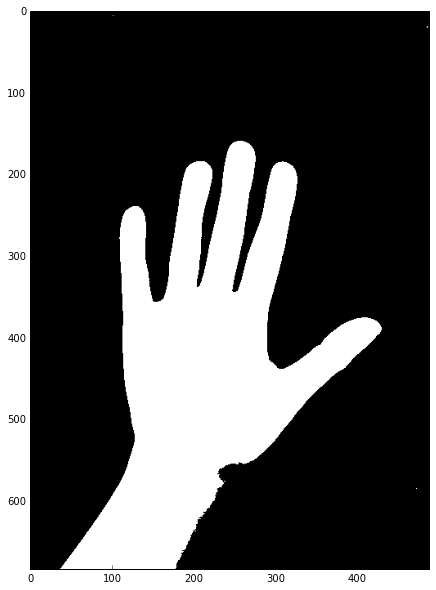

In [32]:
reload(hh)
ans = np.full_like(gb, -1, dtype=np.int64)
ans = hh.expand(gb, ans, 0, 0, 0, radius=1, tol=25, adjacency=4)
ans[ans == -1] = 1
imh.show_image(ans)

В результате такой бинаризации могли образоваться мелкие компоненты, не соответствующие объекту (возникшие, например, из-за шума на фоне). Удалим эти компоненты.

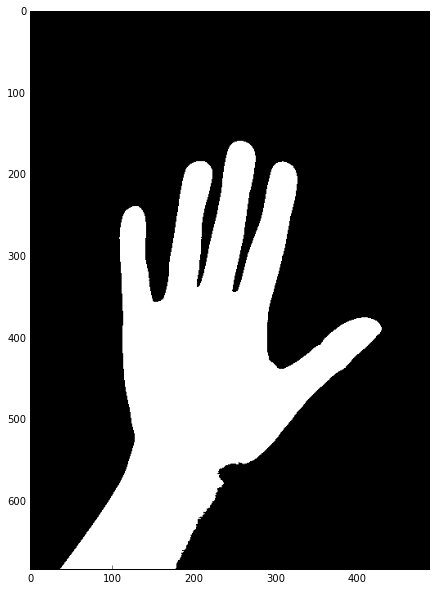

In [46]:
label = skimage.measure.label(ans)
max_area_compn = np.argmax(map(attrgetter('area'), skimage.measure.regionprops(label)))
ans2 = hh.leave_segments(label, [max_area_compn + 1])
imh.show_image(ans2)

Преимущество такого метода по отношению к методу отсечения по порогу в том, что фон является связной компонентой, содержащей левый верхний угол. Таким образом, тёмные места внутри ладони будут относиться к объекту, а не к фону.

Ниже приводится результат бинаризации отсечением по порогу с помощью выбора порога по методу Otsu.

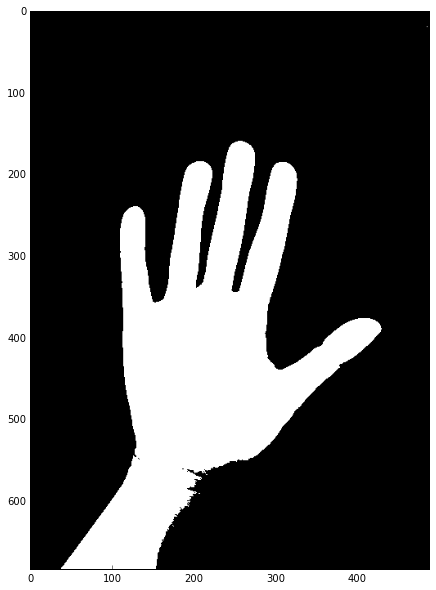

In [48]:
imh.show_image(gb > 0.7 * skimage.filters.threshold_otsu(gb))

Ниже показано, как работают методы бинаризации на разных изображениях.

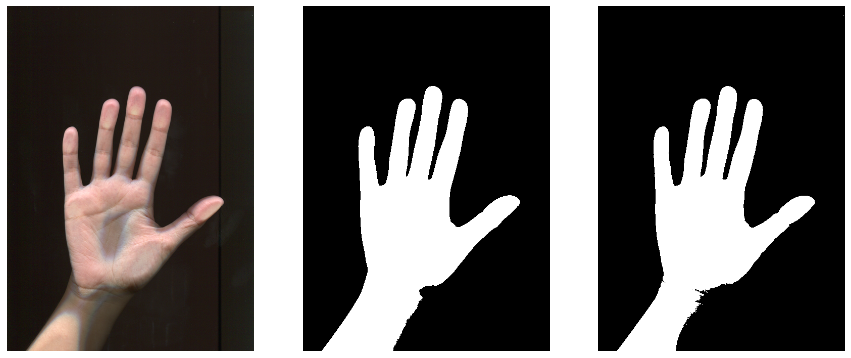

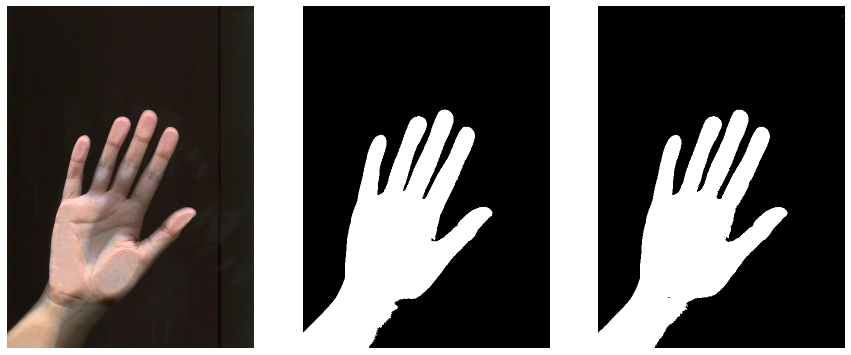

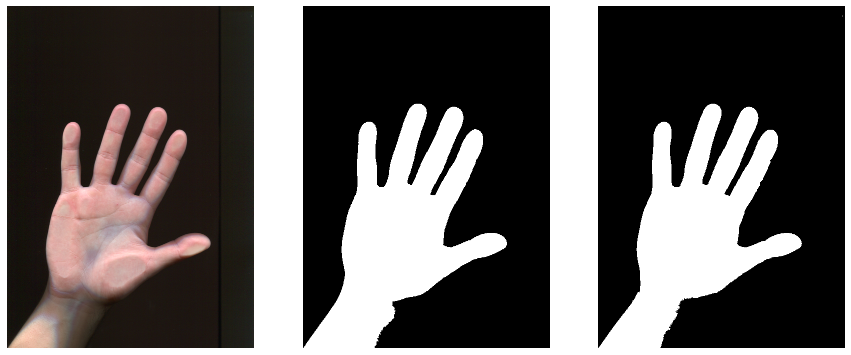

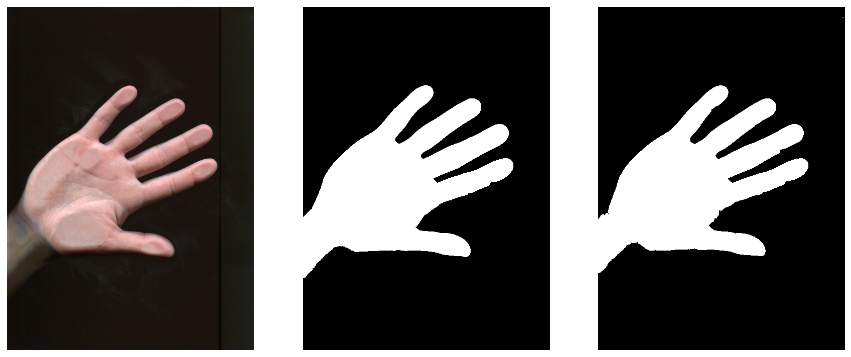

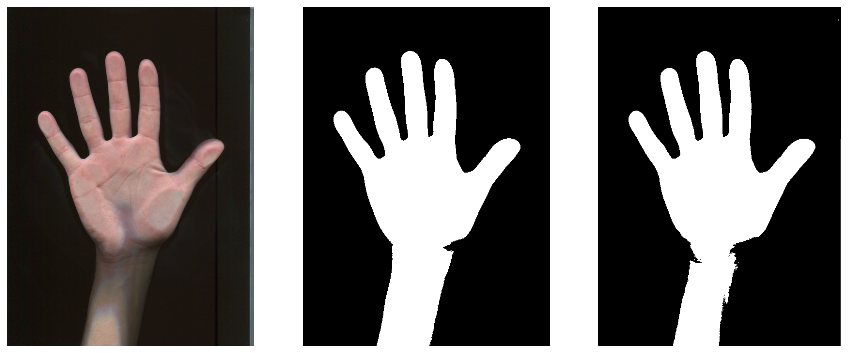

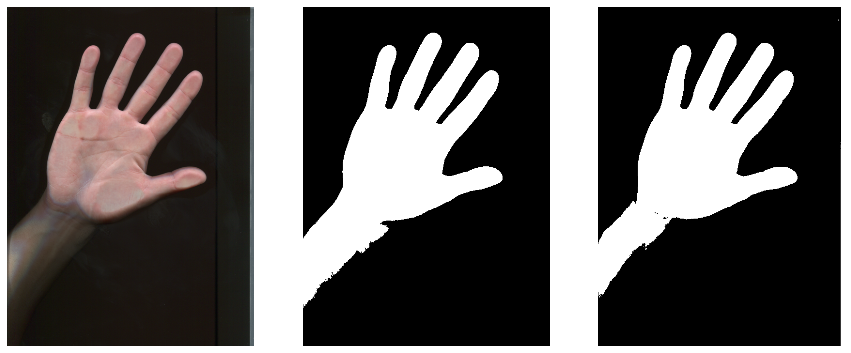

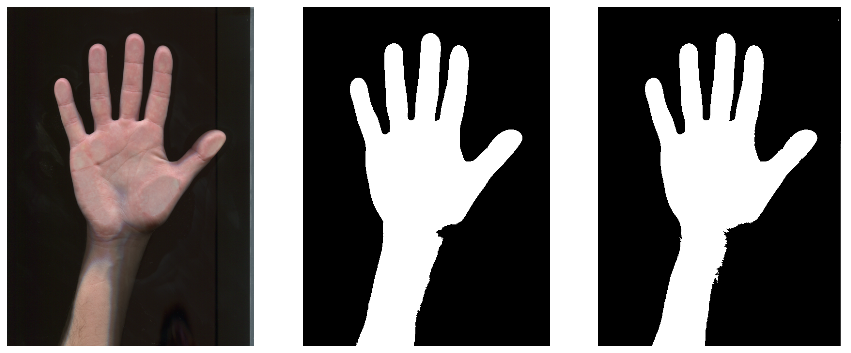

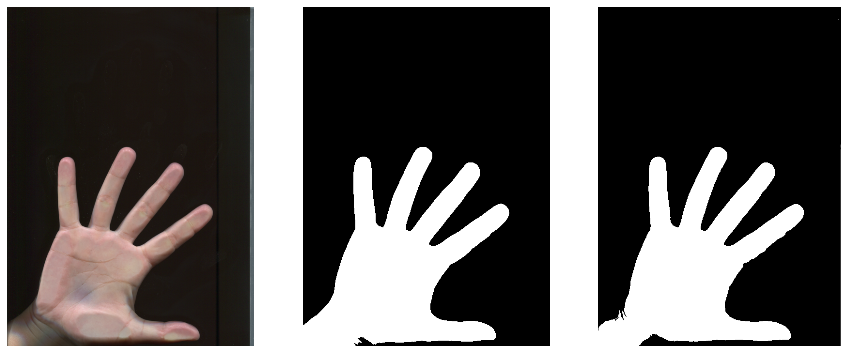

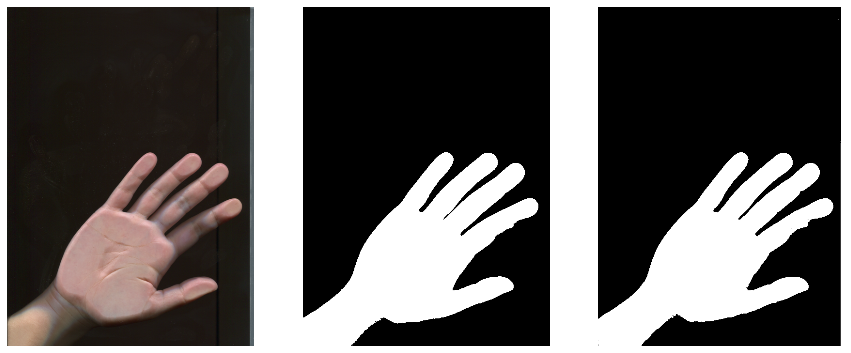

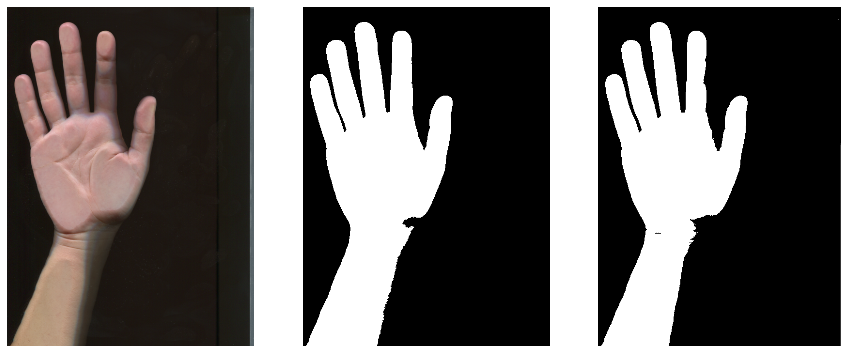

In [50]:
for img_fn in imh.image_names_in_folder('../data/training/')[:10]:
    img = imh.load_image(img_fn)
    gb = imh.intensity(img)
    gb = (gb * 255).astype(np.int64)
    
    ans = np.full_like(gb, -1, dtype=np.int64)
    ans = hh.expand(gb, ans, 0, 0, 0, radius=1, tol=25, adjacency=4)
    ans[ans == -1] = 1
    
    label = skimage.measure.label(ans)
    max_area_compn = np.argmax(map(attrgetter('area'), skimage.measure.regionprops(label)))
    ans2 = hh.leave_segments(label, [max_area_compn + 1])
    
    imh.plot_subfigures([img, ans2, gb > 0.7 * skimage.filters.threshold_otsu(gb)], fig_size=(15, 7))
    plt.show()

Можно наблюдать, что метод заливки даёт сегментацию с менее изрезанными краями руки, чем метод Otsu. Будем использовать далее метод заливки.

#### Поиск центра ладони.

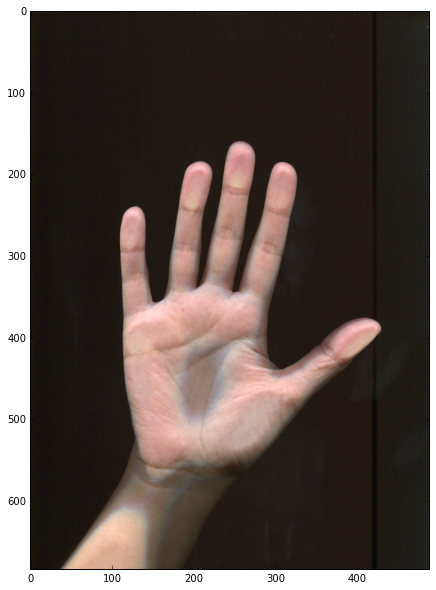

In [323]:
img = imh.load_image('../data/training/001.tif')
imh.show_image(img)
gb = imh.intensity(img)
gb = (gb * 255).astype(np.int64)

Центр ладони оценивается как точка, имеющая максимальное значение distance transform по всем пикселям изображения. Ниже визуализировано преобразование distance transform и показана точка, имеющая максимальное значение distance transform.

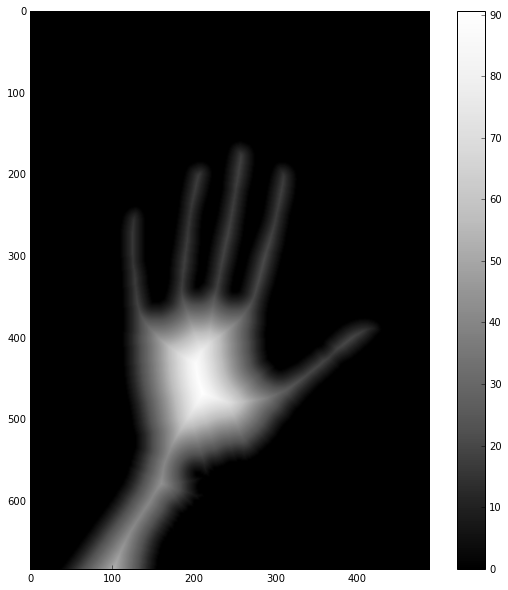

In [324]:
binarized = hh.binarize_hand_img(gb)
binarized = skimage.morphology.closing(binarized, selem=np.ones((3, 3))).astype(int)
med, dt = skimage.morphology.medial_axis(binarized, return_distance=True)
imh.show_image(dt)
plt.colorbar()

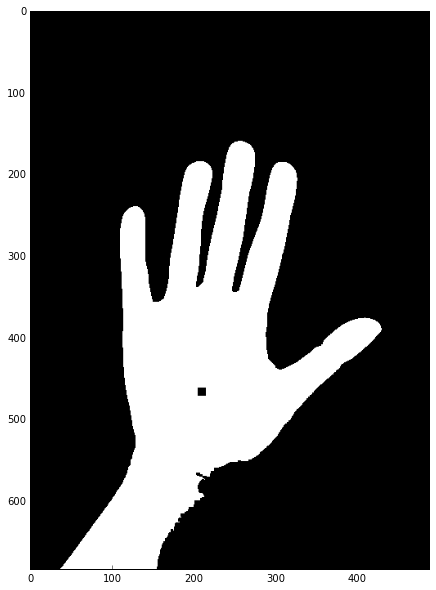

In [325]:
center = (np.argmax(dt.ravel()) / dt.shape[1], np.argmax(dt.ravel()) % dt.shape[1])
bin2 = binarized.copy()
ci, cj = center
bin2[ci - 5:ci + 5, cj - 5:cj + 5] = 0
imh.show_image(bin2)

#### Поиск кончиков пальцев (fingertips).

Сначала произведём поиск краёв объекта. Для поиска краёв объекта (ладони) применяется функция findContours из библиотеки OpenCV. Если возвращается несколько связных контуров, выбирается тот, который содержит центр ладони.

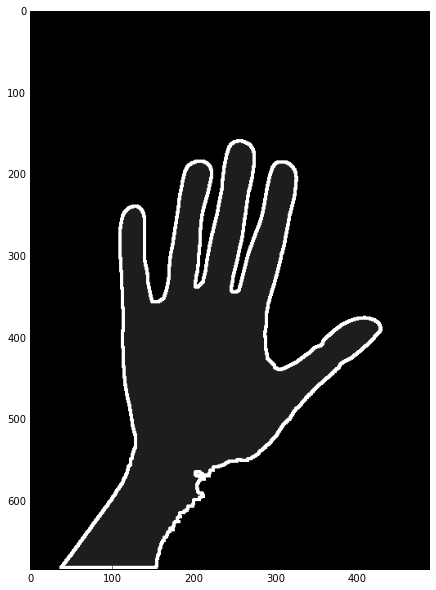

In [329]:
contours = cv2.findContours(binarized.copy().astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
contours = contours[0]
for contour in contours:
    for i in xrange(len(contour)):
        contour[i, 0, 0], contour[i, 0, 1] = contour[i, 0, 1], contour[i, 0, 0]
    if cv2.pointPolygonTest(contour, center, False) >= 0:
        contours = contour
        break
else:
    print 'No contour contains center of hand'
    contours = contours[0]

contours_list = contours.reshape((contours.shape[0], 2))

contours_img = binarized.copy()
for i, pnt in enumerate(contours_list):
    contours_img[pnt[0] - 2:pnt[0] + 2, pnt[1] - 2:pnt[1] + 2] = 10

imh.show_image(contours_img)

В качестве кандидатов на кончики пальцев будем рассматривать точки соприкосновения выпуклой оболочки ладони с самой ладонью. Среди точек-кандидатов отбираются отстоящие от границ изображения не менее, чем на *side_gap* пикселей. Находится точка-кандидат, наиболее удалённая от центра ладони (как правило, это кончик среднего пальца). Далее удаляются из рассмотрения кандидаты, лежащие не ниже прямой, проходящей через центр ладони и перпендикулярной вектору от центра ладони к наиболее удалённому кандидату. Таким образом, удаляются кандидаты, находящиеся на запястье. Далее в течение 4 раз отбирается наиболее удалённая от центра ладони точка-кандидат, не рассмотренная ранее, и из рассмотрения удаляются достаточно близкие к ней точки-кандидаты.

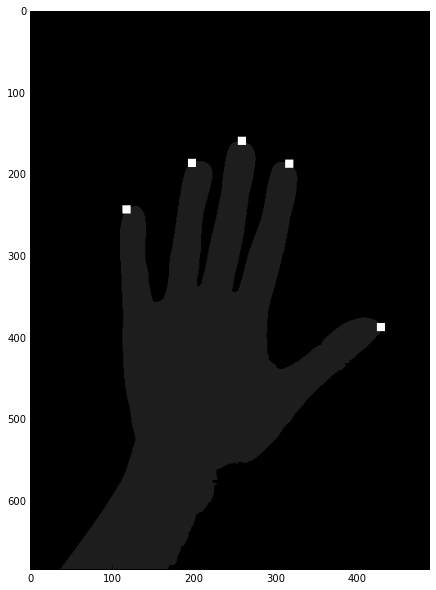

In [204]:
hull_list_initial = cv2.convexHull(contours_list)
hull_list_initial = hull_list_initial.reshape((hull_list_initial.shape[0], 2))
hull_list = hull_list_initial.copy()

side_gap = 5    # ignoring points that lie just near image border
sz = img.shape
hull_list = hull_list[(side_gap < hull_list[:, 0]) & (hull_list[:, 0] < (sz[0] - side_gap)) & \
                      (side_gap < hull_list[:, 1]) & (hull_list[:, 1] < (sz[1] - side_gap))]

fingertips = []
fingertip_radius = 60
fingertip_farthest = None
for i in xrange(5):
    if hull_list.size > 0:
        argmax = np.argmax((hull_list[:, 0] - ci) ** 2 + (hull_list[:, 1] - cj) ** 2)
        max_pnt = hull_list[argmax]
        hull_list = hull_list[(hull_list[:, 0] - max_pnt[0]) ** 2 + \
                              (hull_list[:, 1] - max_pnt[1]) ** 2 >= fingertip_radius ** 2]
        if fingertip_farthest is None:
            fingertip_farthest = max_pnt
            dot = np.dot(hull_list - center, max_pnt - center)
            cross = np.cross(hull_list - center, max_pnt - center)
            hull_list = hull_list[(dot >= 0) | \
                                  ((dot < 0) & (np.abs(cross) >= np.linalg.norm(hull_list - center, axis=1) * \
                                   np.linalg.norm(max_pnt - center) * np.sin(np.pi / 2.0 + np.pi / 10.0)))]
        fingertips.append(max_pnt)

bin3 = binarized.copy()
for pnt in fingertips:
    bin3[pnt[0] - 5:pnt[0] + 5, pnt[1] - 5:pnt[1] + 5] = 10

imh.show_image(bin3)

#### Поиск оснований пальцев (valleys).

В качестве точек-кандидатов на основания пальцев выбираются точки, максимально нарушающие выпуклость фигуры. Для нахождения таких точек применяется функция convexityDefects из библиотеки OpenCV. Среди всех кандидатов отбираются точки, лежащие не ниже прямой, проходящей через центр ладони и перпендикулярной вектору от центра ладони к наиболее удалённому кончику пальца. Далее среди оставшихся кандидатов отбираются 4 наиболее отдалённых от выпуклой оболочки ладони.

[1758, 2175, 181, 520]


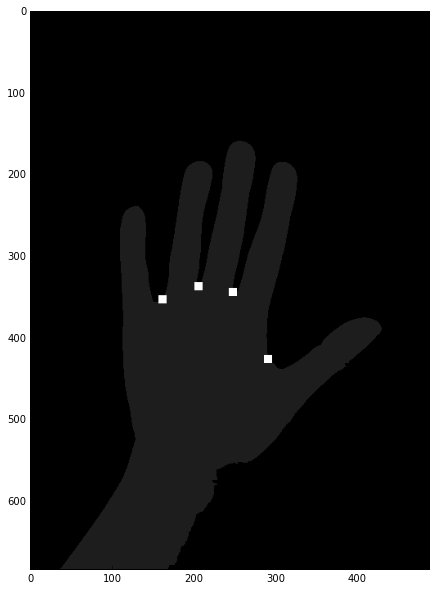

In [225]:
hull_idx = [np.where((contours_list[:, 0] == pnt[0]) & (contours_list[:, 1] == pnt[1]))[0][0]
            for pnt in hull_list_initial]
defects = cv2.convexityDefects(contours_list, np.array(hull_idx))
defects_idx = defects[:, :, 2].ravel()
defects_depth = defects[:, :, 3].ravel()
if fingertip_farthest is not None:
    dot = np.dot(contours_list[defects_idx] - center, fingertip_farthest - center)
    cross = np.cross(contours_list[defects_idx] - center, fingertip_farthest - center)
    defects_depth = defects_depth[(dot >= 0) | \
                                  (np.abs(cross) >= np.linalg.norm(contours_list[defects_idx] - center, axis=1) * \
                                   np.linalg.norm(fingertip_farthest - center) * np.sin(np.pi / 2.0 + np.pi / 8.0))]
    defects_idx = defects_idx[(dot >= 0) | \
                              (np.abs(cross) >= np.linalg.norm(contours_list[defects_idx] - center, axis=1) * \
                               np.linalg.norm(fingertip_farthest - center) * np.sin(np.pi / 2.0 + np.pi / 8.0))]
chosen_defects_idx = defects_idx[np.argsort(defects_depth)[-4:]]
print chosen_defects_idx

bin4 = binarized.copy()
for idx in chosen_defects_idx:
    pnt = contours_list[idx]
    bin4[pnt[0] - 5:pnt[0] + 5, pnt[1] - 5:pnt[1] + 5] = 10

imh.show_image(bin4)

Ниже представлен результат поиска кончиков и оснований пальцев на первых 10 картинках выборки. Для каждого изображения показано 3 стадии обработки: результат бинаризации методом заливки с указанием найденного центра ладони, результат поиска кончиков пальцев, результат поиска оснований пальцев.

Image ../data/training/001.tif


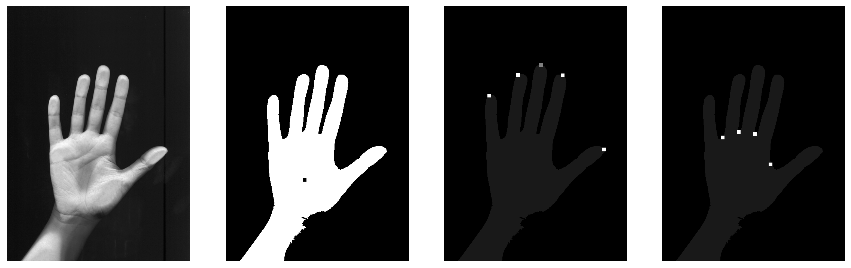

Image ../data/training/002.tif


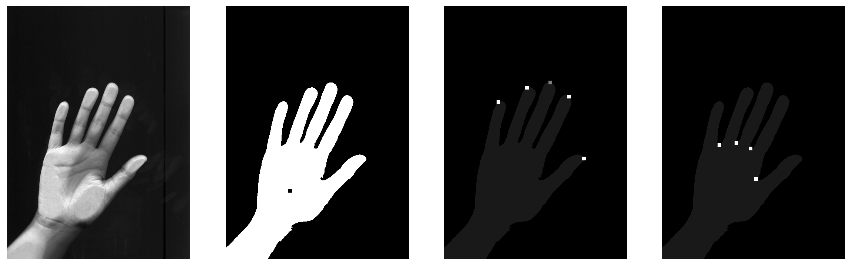

Image ../data/training/003.tif


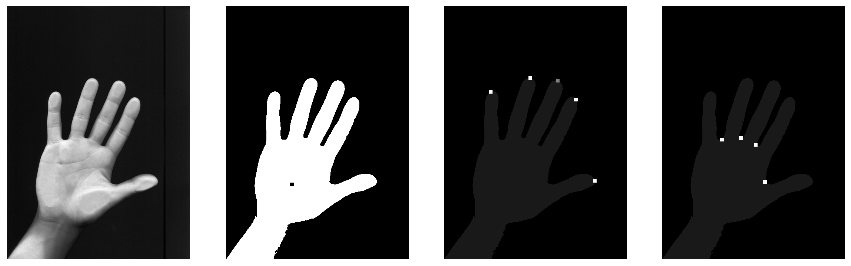

Image ../data/training/004.tif


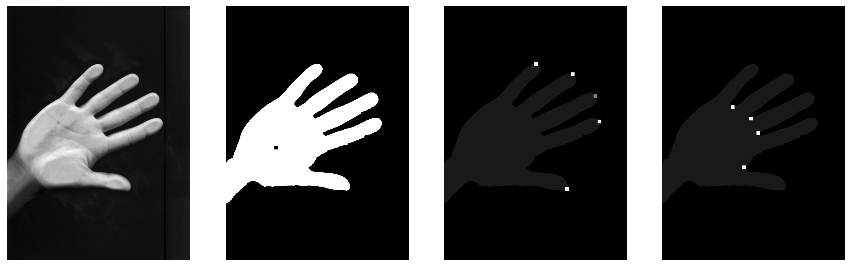

Image ../data/training/005.tif


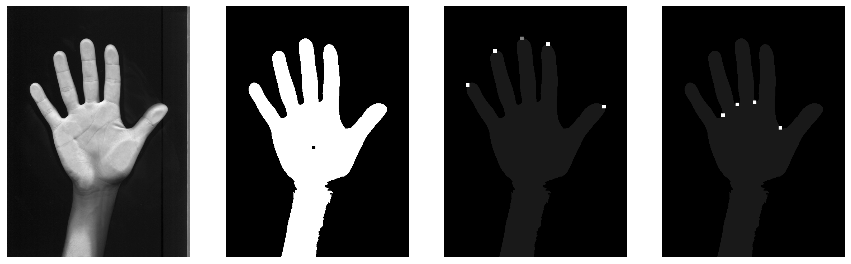

Image ../data/training/006.tif


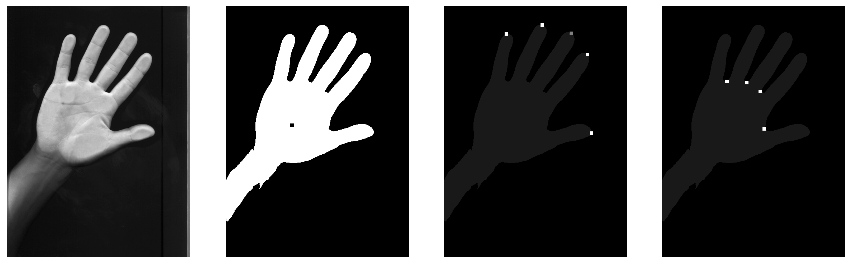

Image ../data/training/007.tif


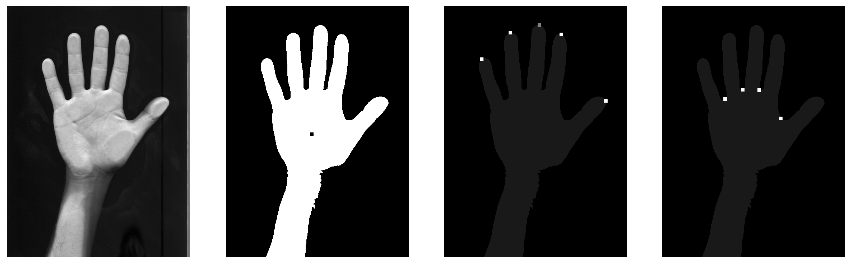

Image ../data/training/008.tif


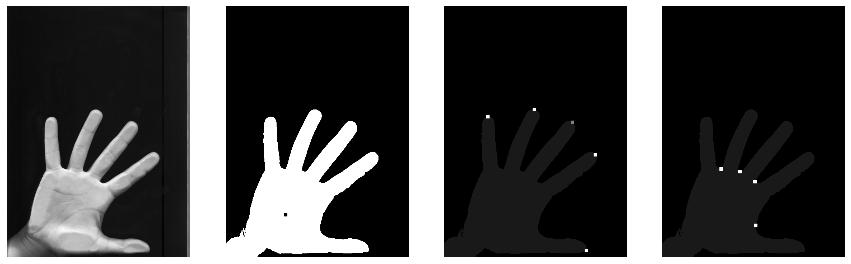

Image ../data/training/009.tif


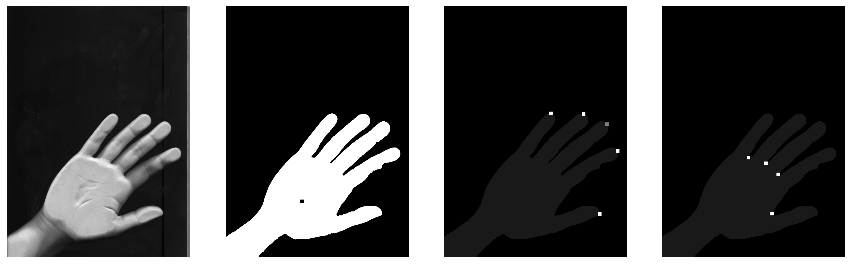

Image ../data/training/010.tif


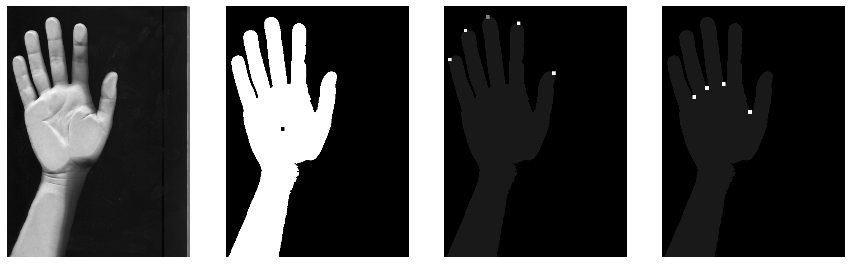

In [322]:
for img_fn in imh.image_names_in_folder('../data/training/')[:10]:
    print 'Image', img_fn
    img = imh.load_image(img_fn)
    gb = (imh.intensity(img) * 255).astype(np.uint8)
    binarized = hh.binarize_hand_img(gb)
    binarized = skimage.morphology.closing(binarized, selem=np.ones((2, 2))).astype(int)
    
    # Finding center
    med, dt = skimage.morphology.medial_axis(binarized, return_distance=True)
    center = (np.argmax(dt.ravel()) / dt.shape[1], np.argmax(dt.ravel()) % dt.shape[1])
    bin2 = binarized.copy()
    ci, cj = center
    bin2[ci - 5:ci + 5, cj - 5:cj + 5] = 0
    
    # Finding contours
    contours = cv2.findContours(binarized.copy().astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    contours = contours[0]
    for contour in contours:
        for i in xrange(len(contour)):
            contour[i, 0, 0], contour[i, 0, 1] = contour[i, 0, 1], contour[i, 0, 0]
        if cv2.pointPolygonTest(contour, center, False) >= 0:
            contours = contour
            break
    else:
        print 'No contour contains center of hand'
        contours = contours[0]
    
    contours_list = contours.reshape((contours.shape[0], 2))
    
    # Finding fingertips
    hull_list_initial = cv2.convexHull(contours_list)
    hull_list_initial = hull_list_initial.reshape((hull_list_initial.shape[0], 2))
    hull_list = hull_list_initial.copy()

    side_gap = 5    # ignoring points that lie just near image border
    sz = img.shape
    hull_list = hull_list[(side_gap < hull_list[:, 0]) & (hull_list[:, 0] < (sz[0] - side_gap)) & \
                          (side_gap < hull_list[:, 1]) & (hull_list[:, 1] < (sz[1] - side_gap))]

    fingertips = []
    fingertip_radius = 60
    fingertip_farthest = None
    for i in xrange(5):
        if hull_list.size > 0:
            argmax = np.argmax((hull_list[:, 0] - ci) ** 2 + (hull_list[:, 1] - cj) ** 2)
            max_pnt = hull_list[argmax]
            hull_list = hull_list[(hull_list[:, 0] - max_pnt[0]) ** 2 + \
                                  (hull_list[:, 1] - max_pnt[1]) ** 2 >= fingertip_radius ** 2]
            if fingertip_farthest is None:
                fingertip_farthest = max_pnt
                dot = np.dot(hull_list - center, max_pnt - center)
                cross = np.cross(hull_list - center, max_pnt - center)
                hull_list = hull_list[(dot >= 0) | \
                                      ((dot < 0) & (np.abs(cross) >= np.linalg.norm(hull_list - center, axis=1) * \
                                       np.linalg.norm(max_pnt - center) * np.sin(np.pi / 2.0 + np.pi / 10.0)))]
            fingertips.append(max_pnt)

    bin3 = binarized.copy()
    for pnt in fingertips:
        if np.all(np.isclose(pnt - fingertip_farthest, 0)):
            bin3[pnt[0] - 5:pnt[0] + 5, pnt[1] - 5:pnt[1] + 5] = 5
        else:
            bin3[pnt[0] - 5:pnt[0] + 5, pnt[1] - 5:pnt[1] + 5] = 10
    
    # Finding valleys
    hull_idx = [np.where((contours_list[:, 0] == pnt[0]) & (contours_list[:, 1] == pnt[1]))[0][0]
            for pnt in hull_list_initial]
    defects = cv2.convexityDefects(contours_list, np.array(hull_idx))
    defects_idx = defects[:, :, 2].ravel()
    defects_depth = defects[:, :, 3].ravel()
    if fingertip_farthest is not None:
        dot = np.dot(contours_list[defects_idx] - center, fingertip_farthest - center)
        cross = np.cross(contours_list[defects_idx] - center, fingertip_farthest - center)
        defects_depth = defects_depth[(dot >= 0) | \
                                      (np.abs(cross) >= np.linalg.norm(contours_list[defects_idx] - center, axis=1) * \
                                       np.linalg.norm(fingertip_farthest - center) * np.sin(np.pi / 2.0 + np.pi / 8.0))]
        defects_idx = defects_idx[(dot >= 0) | \
                                  (np.abs(cross) >= np.linalg.norm(contours_list[defects_idx] - center, axis=1) * \
                                   np.linalg.norm(fingertip_farthest - center) * np.sin(np.pi / 2.0 + np.pi / 8.0))]
    chosen_defects_idx = defects_idx[np.argsort(defects_depth)[-4:]]

    bin4 = binarized.copy()
    valleys = []
    for idx in chosen_defects_idx:
        pnt = contours_list[idx]
        valleys.append(pnt)
        bin4[pnt[0] - 5:pnt[0] + 5, pnt[1] - 5:pnt[1] + 5] = 10
    
    imh.plot_subfigures([gb, bin2, bin3, bin4], fig_size=(15, 7))
    plt.show()

#### Построение ломаной, вычисление длин звеньев ломаной.

Для построения ломаной, соединяющей кончики и основания пальцев, необходимо найти кончики и основания пальцев и отсортировать их по углу. Чтобы это сделать, изначально производится такой поворот, что вектор от центра ладони к наиболее удалённому кончику пальца располагался строго вверх. Таким образом, углы наклона векторов от центра ладони к кончикам пальцев будут положительны, если считать нулевым углом угол вектора (0, -1). Чтобы при повороте часть изображения не потерялась, к изображению сначала добавляются пустое место со всех сторон, а затем удаляется.

Ниже приведены результаты сортировки ключевых точек (кончиков и оснований пальцев) по углу. 

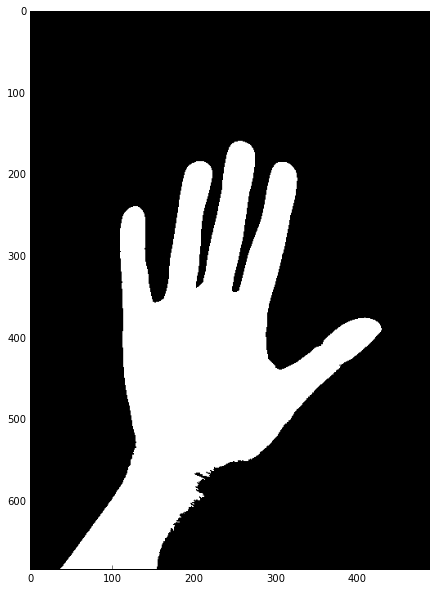

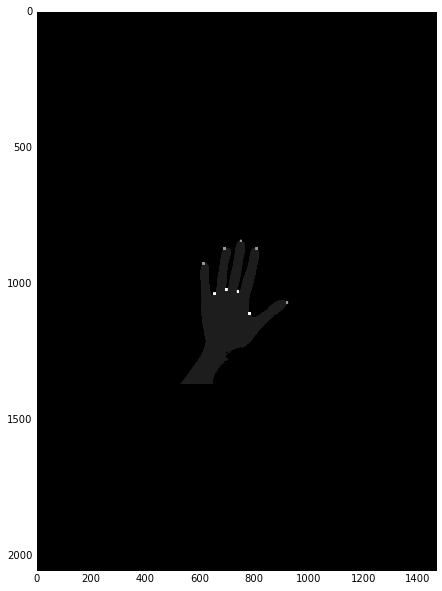

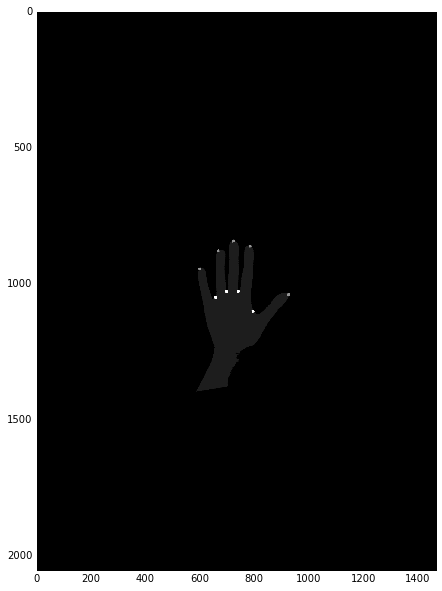

In [330]:
img = imh.load_image('../data/training/001.tif')
gb = (imh.intensity(img) * 255).astype(np.uint8)
binarized = hh.binarize_hand_img(gb)
imh.show_image(binarized)
plt.show()
fingertips, valleys, center = hh.get_fingertips_and_valleys(binarized, return_center=True)

bin_w_key_pts = np.zeros((binarized.shape[0] * 3, binarized.shape[1] * 3), dtype=np.int64)
bin_w_key_pts[binarized.shape[0]:2 * binarized.shape[0], binarized.shape[1]:2 * binarized.shape[1]] = \
    binarized.copy()
for pnt in fingertips:
    bin_w_key_pts[binarized.shape[0] + pnt[0] - 5:binarized.shape[0] + pnt[0] + 5, \
                  binarized.shape[1] + pnt[1] - 5:binarized.shape[1] + pnt[1] + 5] = 5
for pnt in valleys:
    bin_w_key_pts[binarized.shape[0] + pnt[0] - 5:binarized.shape[0] + pnt[0] + 5, \
                  binarized.shape[1] + pnt[1] - 5:binarized.shape[1] + pnt[1] + 5] = 10
imh.show_image(bin_w_key_pts)
plt.show()
fingertips_dist_sq = map(lambda pnt: ((pnt - np.array(center)) ** 2).sum(), fingertips)
fingertip_farthest = fingertips[np.argmax(fingertips_dist_sq)]
rot_angle = np.degrees(np.pi - hh.aligned_angle(fingertip_farthest - center))
bin_rot = sp.misc.imrotate(bin_w_key_pts, rot_angle, interp='nearest')
imh.show_image(bin_rot)
plt.show()

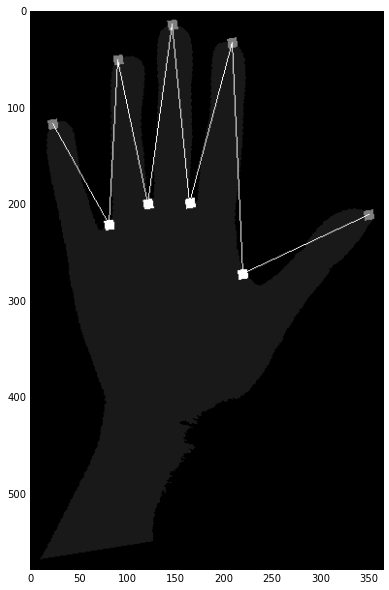

In [331]:
# Finding center
med, dt = skimage.morphology.medial_axis(bin_rot, return_distance=True)
center_rot = (np.argmax(dt.ravel()) / dt.shape[1], np.argmax(dt.ravel()) % dt.shape[1])

# Acquiring fingertips from rotated image and sorting them by angle
fingertips_label = skimage.measure.label(bin_rot == 127, neighbors=8, connectivity=3)
fingertips_rot = map(attrgetter('centroid'), skimage.measure.regionprops(fingertips_label))
fingertips_rot = np.array(fingertips_rot, dtype=np.int64)
fingertips_angles = np.array(map(lambda pnt: hh.aligned_angle(pnt - center_rot), fingertips_rot))
fingertips_rot = fingertips_rot[np.argsort(fingertips_angles)]

# Acquiring valleys from rotated image and sorting them by angle
valleys_label = skimage.measure.label(bin_rot == 255, neighbors=8, connectivity=3)
valleys_rot = map(attrgetter('centroid'), skimage.measure.regionprops(valleys_label))
valleys_rot = np.array(valleys_rot, dtype=np.int64)
valleys_angles = np.array(map(lambda pnt: hh.aligned_angle(pnt - center_rot), valleys_rot))
valleys_rot = valleys_rot[np.argsort(valleys_angles)]

if len(fingertips_rot) < 5 or len(valleys_rot) < 4:
    print 'Not all key points found'
else:
    key_points = []
    for i in xrange(4):
        key_points.extend([fingertips_rot[i], valleys_rot[i]])
    key_points.append(fingertips_rot[4])
    features = np.diff(key_points, axis=0)
    features = np.sqrt(features[:, 0] ** 2 + features[:, 1] ** 2)

    bin_rot_with_lines = np.empty((bin_rot.shape[0], bin_rot.shape[1], 3), dtype=np.uint8)
    bin_rot_with_lines[:, :, 0] = bin_rot_with_lines[:, :, 1] = bin_rot_with_lines[:, :, 2] = bin_rot.copy()
    plt.figure(figsize=(10, 10))
    for i in xrange(1, len(key_points)):
        pnt1 = tuple(key_points[i - 1])
        pnt2 = tuple(key_points[i])
        pnt1 = (pnt1[1], pnt1[0])
        pnt2 = (pnt2[1], pnt2[0])
        cv2.line(bin_rot_with_lines, pnt1, pnt2, [255, 255, 255])
    
    bin_rot_with_lines = imh.crop_black_border(bin_rot_with_lines)
    imh.show_image(bin_rot_with_lines)
    plt.show()

### Класс Expert

#### Поиск ближайших соседей к каждому изображению в пространстве признаков.

Для каждого изображения составляется вектор длин отрезков ломаной, описанной и проиллюстрированной выше. В качестве признаков изображения выбираются длины отрезков данной ломаной. Ниже приведена таблица значений признаков для первых 10 изображений выборки.

In [314]:
img_filenames = imh.image_names_in_folder('../data/training')


def get_short_fn_wo_ext(filename):
    short_fn = os.path.split(filename)[-1]
    return short_fn[:short_fn.rfind('.')]


short_filenames = map(int, map(get_short_fn_wo_ext, img_filenames))
n_features = 8
X = pd.DataFrame(index=short_filenames, columns=map(lambda i: 'Feature {}'.format(i), np.arange(n_features)))


def process_image(img_fn, short_fn):
    img = imh.load_image(img_fn)
    gb = (imh.intensity(img) * 255).astype(np.uint8)
    binarized = hh.binarize_hand_img(gb)
    fingertips, valleys, center = hh.get_fingertips_and_valleys(binarized, return_center=True)
    features = hh.get_features(binarized, fingertips, valleys, center)
    return (short_fn, features)


features_all = Parallel(n_jobs=7)(delayed(process_image)(img_fn, short_filenames[i]) 
                                  for i, img_fn in enumerate(img_filenames))
#features_all = [process_image(img_fn, short_filenames[i]) for i, img_fn in enumerate(img_filenames)]


for short_fn, features in features_all:
    if features is not None and len(features) == 8:
        X.loc[short_fn] = features

display(X.iloc[:10])

Feature 0 Feature 1 Feature 2 Feature 3 Feature 4 Feature 5 Feature 6  \
1      143.6   239.253   171.732   185.874   187.673   152.191   170.238   
2    136.473   237.019   171.724   185.194   185.311   152.191   170.188   
3    129.248   236.028   159.625   180.602   181.108   163.817   181.069   
4    124.619   234.036   163.322   179.234   179.354   160.823   178.281   
5    130.173   235.767    164.56   182.858    184.44   164.137   181.397   
6    127.059   236.764   162.561   180.228   181.463    164.56   182.275   
7    129.711   234.337   165.421   181.221     184.7   163.811   185.132   
8    153.222   255.237   179.889   191.943   196.461   177.133   187.417   
9    128.222   249.339   172.679   190.948    196.86   169.098   188.024   
10   124.619   250.162   172.977   194.031   198.013   172.256   187.171   

   Feature 7  
1     119.08  
2    116.297  
3    134.063  
4    129.808  
5     133.66  
6    132.201  
7    131.822  
8    152.201  
9    134.618  
10   127.534

Для каждого изображения находятся 3 ближайших соседа в пространстве признаков. Ниже приведена таблица 3 ближайших соседей для первых 10 изображений выборки.

In [321]:
X = X.dropna()

neighbors = sklearn.neighbors.NearestNeighbors(n_neighbors=4, algorithm='auto').fit(X)
distances, indices = neighbors.kneighbors(X)
filenames = np.empty((indices.shape[0], indices.shape[1] - 1), dtype=np.int64)
for i in xrange(indices.shape[0]):
    for j in xrange(1, indices.shape[1]):
        filenames[i, j - 1] = X.index[indices[i, j]]

nearest_df = pd.DataFrame(index=X.index, columns=map(lambda x: 'Neighbor #{}'.format(x), (1, 2, 3)),
                          data=filenames)
display(nearest_df.iloc[:10])
nearest_df.to_csv('../data/nearest_df.csv')

Neighbor #1  Neighbor #2  Neighbor #3
1             2           90           82
2             1           13          146
3             6            5            7
4             6            3            5
5             7            6            3
6             3            5            7
7             5            6            3
8            67           66          129
9            65           10           11
10           65            9           11

#### Построение кластеризации методом DBSCAN.

Производится кластеризация изображений в пространстве признаков. Этим самым устанавливается, принадлежат ли различные ладони одним и тем же людям, и сколько всего людей могло быть задействовано в сканировании ладоней.

Выбор алгоритма DBSCAN обусловлен несколькими причинами:
* способность алгоритма автоматически установить число кластеров
* достаточно высокая производительность (при использовании структур данных, обеспечивающих быстрый поиск ближайших соседей)
* способность адаптироваться к разным формам кластеров (см. http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)

In [338]:
scaler = sklearn.preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

algo = sklearn.cluster.DBSCAN(eps=1.0, metric='euclidean', algorithm='auto', min_samples=1)
pred = algo.fit_predict(X_scaled)
pred

array([ 0,  0,  1,  1,  1,  1,  1,  2,  3,  3,  3,  4,  4,  4,  5,  6,  3,
        3,  3,  3,  3,  7,  7,  3,  8,  8,  8,  8,  9, 10,  7,  7, 11, 12,
       13,  3, 14, 15, 14,  3, 16, 16, 16, 16,  3,  3, 13, 10, 17,  3, 18,
        2,  3, 19,  3,  3,  3,  3,  3,  3,  3, 20,  3, 20, 21, 22, 23, 10,
        1,  1, 20, 20, 20, 24, 25, 26, 26, 26, 27, 10, 28, 23, 10, 29, 29,
       30, 30, 31, 32, 33, 20,  1, 34,  1, 35, 35, 35,  1,  1])

In [334]:
n_clusters = pred.max() + 1
print 'Оценённое число людей:', n_clusters, '\n'
clustering = [[] for i in xrange(n_clusters)]
for i in xrange(pred.size):
    clustering[pred[i]].append(X.index[i])

for i in xrange(n_clusters):
    print 'Изображения ладони человека #{}: \t{}'.format(i + 1, clustering[i]) 

Оценённое число людей: 36 

Изображения ладони человека #1: 	[1, 2]
Изображения ладони человека #2: 	[3, 4, 5, 6, 7, 97, 99, 144, 146, 155, 157]
Изображения ладони человека #3: 	[8, 67]
Изображения ладони человека #4: 	[9, 10, 11, 17, 18, 19, 20, 21, 24, 46, 51, 56, 57, 65, 68, 76, 77, 78, 79, 81, 82, 86, 90]
Изображения ладони человека #5: 	[12, 13, 14]
Изображения ладони человека #6: 	[15]
Изображения ладони человека #7: 	[16]
Изображения ладони человека #8: 	[22, 23, 35, 36]
Изображения ладони человека #9: 	[26, 27, 28, 29]
Изображения ладони человека #10: 	[31]
Изображения ладони человека #11: 	[34, 63, 96, 120, 124]
Изображения ладони человека #12: 	[37]
Изображения ладони человека #13: 	[39]
Изображения ладони человека #14: 	[41, 60]
Изображения ладони человека #15: 	[47, 50]
Изображения ладони человека #16: 	[49]
Изображения ладони человека #17: 	[52, 53, 54, 55]
Изображения ладони человека #18: 	[64]
Изображения ладони человека #19: 	[66]
Изображения ладони человека #20: 	[71]


### Выводы

Отсканированные изображения ладоней поддаются бинаризации и анализу вне зависимости от расположения пальцев и руки. На основе таких изображений можно строить как простые, так и сложные признаковые описания, решать задачу кластеризации, решать задачу идентификации человека по ладони или верификации человека по ладони.

Эффективное решение задачи кластеризации требует наличия корректной кластеризации для части изображений с целью настройки параметров алгоритма кластеризации.